In [175]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

sns.set_theme(style="ticks", context="talk")
plt.style.use("dark_background")


from sklearn.model_selection import (
    StratifiedShuffleSplit, cross_val_score, learning_curve, RepeatedStratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from scipy.stats.mstats import winsorize

import joblib
import re
import warnings
warnings.filterwarnings("ignore")

In [176]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')

In [177]:
#2. EDA 
# ============================================================

print("Train shape:", train_df.shape)
print("Test shape:",  test_df.shape)

print("\n=== Missing values (Train) ===")
print(train_df.isnull().sum())

Train shape: (891, 12)
Test shape: (418, 11)

=== Missing values (Train) ===
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


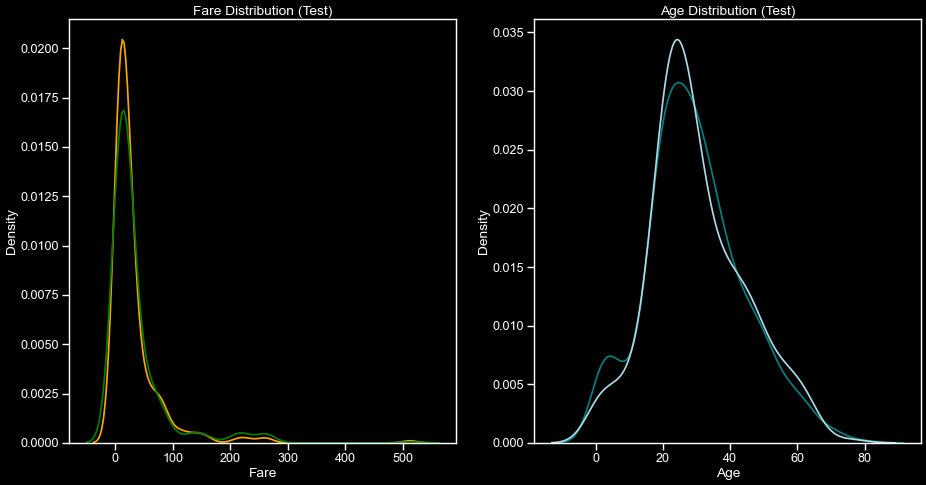

In [178]:

plt.subplot(1,2,1)
sns.kdeplot(train_df['Fare'],  color='orange')
plt.title('Fare Distribution (Train)')

plt.subplot(1,2,2)
sns.kdeplot(train_df['Age'] , color='teal', )
plt.title('Age Distribution (Train)')


plt.subplot(1,2,1)
sns.kdeplot(test_df['Fare'],  color='green')
plt.title('Fare Distribution (Test)')

plt.subplot (1,2,2)
sns.kdeplot(test_df['Age'] , color='lightblue', )
plt.title('Age Distribution (Test)')

plt.show()

<Figure size 770x550 with 0 Axes>

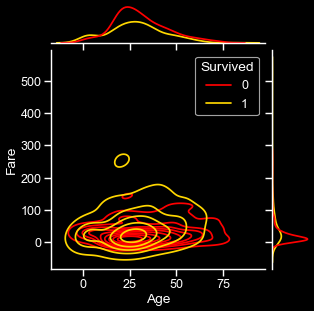

<Figure size 770x550 with 0 Axes>

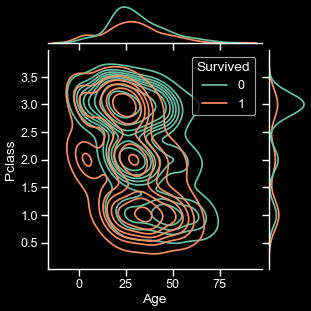

In [179]:
plt.figure(figsize=(14,10)) 
sns.jointplot(data=train_df, x='Age', y='Fare', hue='Survived'
              , kind='kde'
              , palette=['red', 'gold']
              )  
plt.show()

plt.figure(figsize=(14,10)) 
sns.jointplot(data=train_df, x='Age', y='Pclass', hue='Survived'
              , kind='kde'
              , palette='Set2'
              )  
plt.show()

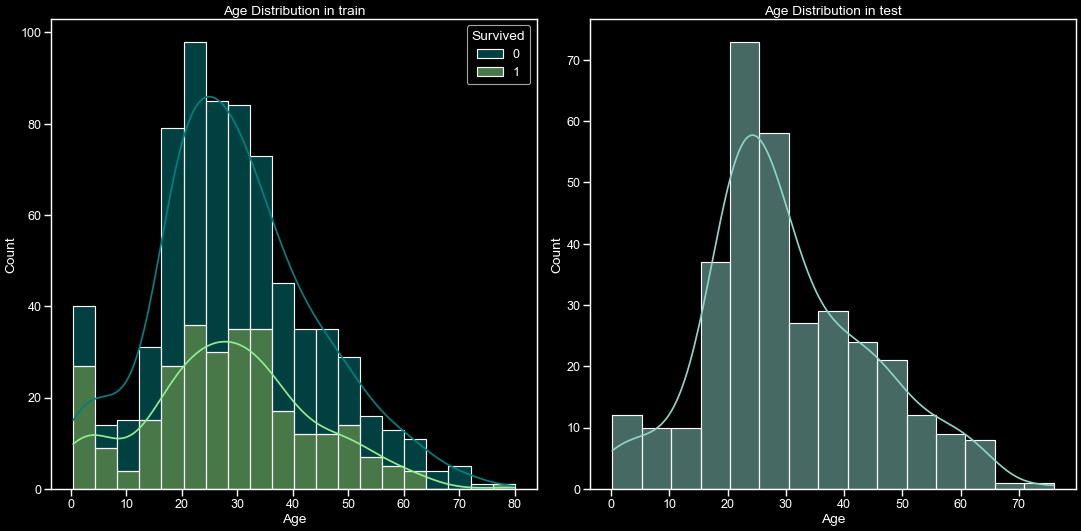

In [180]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(data=train_df, x="Age", kde=True, hue='Survived', palette=['teal', 'lightgreen'], multiple="stack")
plt.title("Age Distribution in train")

plt.subplot(1,2,2)
sns.histplot(data=test_df, x="Age", kde=True, palette=['teal', 'lightgreen'], multiple="stack")
plt.title("Age Distribution in test")

plt.tight_layout()
plt.show()

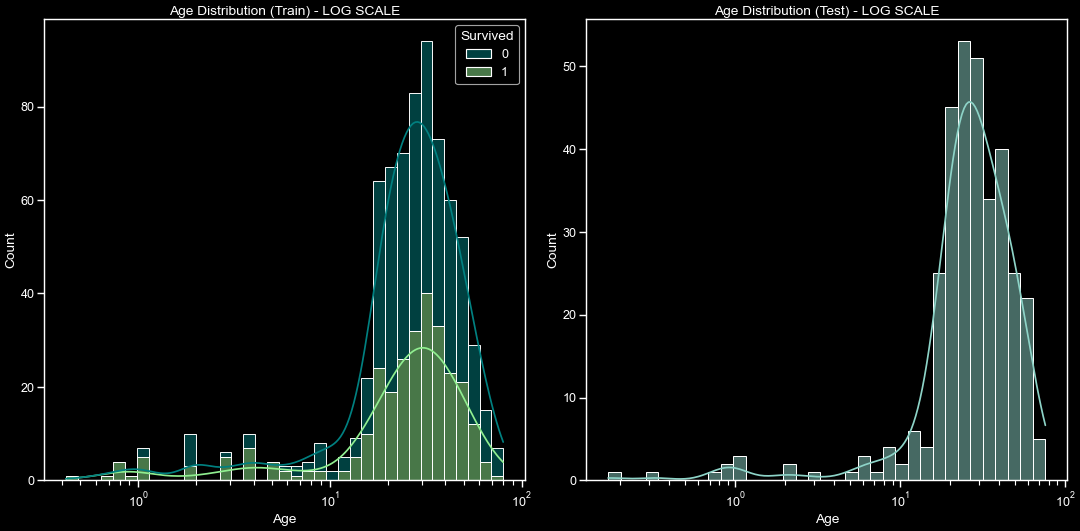

In [181]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(
    data=train_df, 
    x="Age", 
    kde=True, 
    hue='Survived', 
    palette=['teal', 'lightgreen'], 
    multiple="stack",
    log_scale=True       # <-- логарифмическая шкала по X
)
plt.title("Age Distribution (Train) - LOG SCALE")

plt.subplot(1,2,2)
sns.histplot(
    data=test_df, 
    x="Age", 
    kde=True, 
    palette=['teal', 'lightgreen'], 
    multiple="stack",
    log_scale=True       # <-- логарифмическая шкала по X
)
plt.title("Age Distribution (Test) - LOG SCALE")

plt.tight_layout()
plt.show()


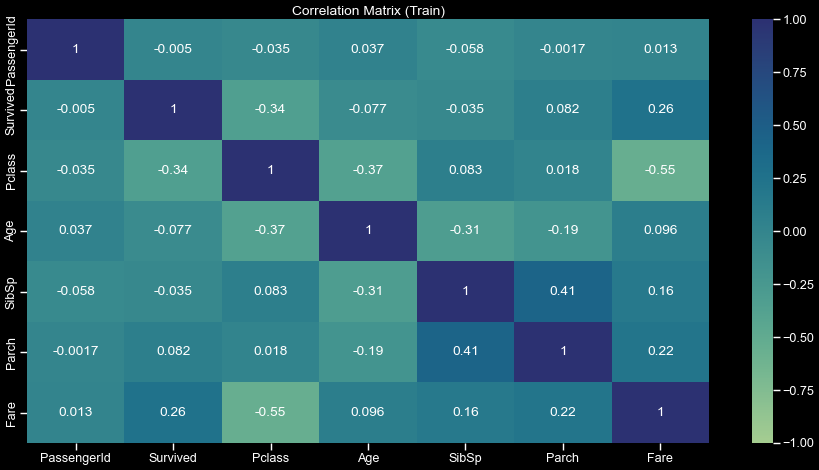

In [182]:

num_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='crest', center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix (Train)")
plt.show()

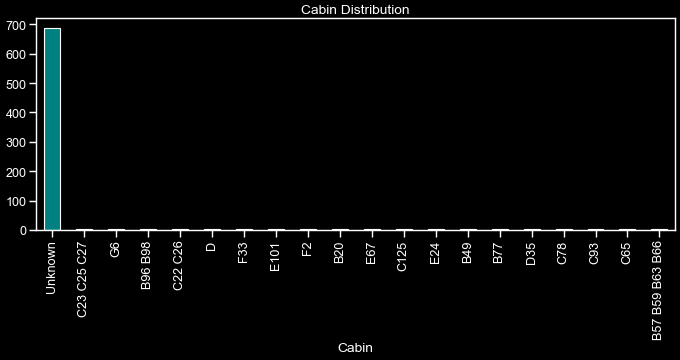

In [137]:
(train_df['Cabin']
 .fillna('Unknown')
 .value_counts()
 .head(20)   
 .plot(kind='bar', figsize=(15,5), color='teal', title='Cabin Distribution')
)
plt.show()

In [183]:
#3. OUTLIERS AND SCEWED DISTR
# ============================================================

def log_transform(series):
    return np.log1p(series)  # log(1 + x)

# Winsorizatio
def winsorize_series(series, limits=(0.01, 0.01)):
    return winsorize(series, limits=limits)


# 1) log Fare
train_df['Fare'] = log_transform(train_df['Fare'])
test_df['Fare']  = log_transform(test_df['Fare'])

# 2) Winsorize Age
train_df['Age'] = log_transform(train_df['Age'])
test_df['Age']  = log_transform(test_df['Age'])

In [184]:
# --- 3.3 Feature Engineering ---


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # Title
    def extract_title(name: str) -> str:
        match = re.search(r' ([A-Za-z]+)\.', name)
        return match.group(1) if match else ""
    
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    df['Title'] = df['Title'].replace(
        ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir',
         'Jonkheer','Dona'], 'Rare'
    )
    
    def extract_deck(cabin: str) -> str:
        if pd.isna(cabin) or cabin.strip() == "":
            return "Unknown"
        else :
            return cabin[0].upper()  # For instance, 'C85' -> 'C'
        
    def extract_ticket_prefix(ticket: str) -> str:
        ticket = ticket.replace(".", "").replace("/", "").replace("\\", "")
        parts = ticket.split()
        prefix = [p for p in parts if not p.isdigit()]
        if len(prefix) > 0:
            return prefix[0].strip().upper()
        else:
            return "NoPrefix"
        
    def get_surname(name: str) -> str:
        if pd.isna(name):
            return "Unknown"
        parts = name.split(',')
        if len(parts) > 1:
            return parts[0].strip().upper()
        return "Unknown"   
        
    df['Deck'] = df['Cabin'].apply(extract_deck)    

    df['TicketPrefix'] = df['Ticket'].apply(extract_ticket_prefix)
    
    
    # HasCabin
    df['HasCabin'] = df['Cabin'].notnull().astype(int)
    
    # FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # IsAlone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # input median value to age
    df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

    # Embarked by mode
    common_emb = df['Embarked'].mode()[0]
    df['Embarked'] = df['Embarked'].fillna(common_emb)
    
    # Fare by median
    fare_median = df['Fare'].median()
    df['Fare'] = df['Fare'].fillna(fare_median)
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    
    df['Surname'] = df['Name'].apply(get_surname)


    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 20, 40, 60, 100], 
                            labels=['Child','Teen','Adult','Mature','Senior'])
    
    df['TitlePclass'] = df['Title'].astype(str) + "_" + df['Pclass'].astype(str)
    
    # interaction feature
    df['Age*Class'] = df['Age'] * df['Pclass']
    
    df['FareGroup'] = pd.qcut(df['Fare'], 4, labels=['low','mid','high','very_high'])
    
    return df


train_df = feature_engineering(train_df)
test_df  = feature_engineering(test_df)

In [196]:
#4. Features
# ============================================================
features = [
    # Category 
    'Pclass',     
    'Sex',
    'Embarked',
    'Title',
    'Deck',
    'TicketPrefix',
    'TitlePclass', 
    'AgeGroup',     
    'FareGroup',    

    # Numer
    'HasCabin',
    'FamilySize',
    'IsAlone',
    'Age',
    'Fare',
    'Age*Class',
    'FarePerPerson'
]
target = 'Survived'

X = train_df[features].copy()
y = train_df[target].copy()

X_test = test_df[features].copy()

cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

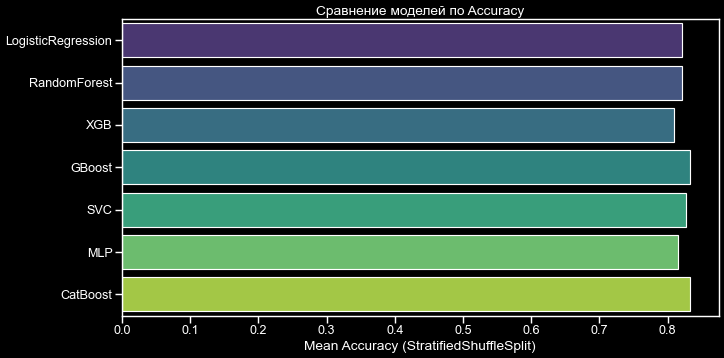

In [197]:
def evaluate_models(X, y, models, preprocessor, n_splits=5, n_repeats=5, random_state=42):
    """
    Evaluates multiple models using RepeatedStratifiedKFold cross-validation.

    Parameters:
    X (pd.DataFrame): Feature matrix.
    y (pd.Series): Target vector.
    models (dict): Dictionary of models with model names as keys.
    preprocessor (ColumnTransformer): Preprocessing pipeline.
    n_splits (int): Number of splits for StratifiedKFold.
    n_repeats (int): Number of repeats for StratifiedKFold.
    random_state (int): Random seed.

    Returns:
    pd.DataFrame: DataFrame with evaluation metrics for each model.
    """
    sss = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

    results = {}

    for model_name, model in models.items():
        # pipeline (preprocessor -> model)
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        acc_scores = []
        f1_scores = []
        roc_scores = []

        for train_index, val_index in sss.split(X, y):
            X_train_split, X_val_split = X.iloc[train_index], X.iloc[val_index]
            y_train_split, y_val_split = y.iloc[train_index], y.iloc[val_index]

            # fit
            pipeline.fit(X_train_split, y_train_split)
            # predict
            y_pred_val = pipeline.predict(X_val_split)

            # metrics
            acc = accuracy_score(y_val_split, y_pred_val)
            f1v = f1_score(y_val_split, y_pred_val)

            acc_scores.append(acc)
            f1_scores.append(f1v)

            # ROC-AUC + check if model has predict proba (pay attention to SVC)
            if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):
                try:
                    y_proba_val = pipeline.predict_proba(X_val_split)[:, 1]
                    roc = roc_auc_score(y_val_split, y_proba_val)
                    roc_scores.append(roc)
                except:
                    roc_scores.append(np.nan)
            else:
                roc_scores.append(np.nan)

        # mean и std
        acc_mean, acc_std = np.mean(acc_scores), np.std(acc_scores)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
        if all(~np.isnan(roc_scores)):  # if not NaN
            roc_mean, roc_std = np.mean(roc_scores), np.std(roc_scores)
            roc_str = f"{roc_mean:.4f} ± {roc_std:.4f}"
        else:
            roc_str = "NA"

        results[model_name] = {
            'Accuracy': f"{acc_mean:.4f} ± {acc_std:.4f}",
            'F1-score': f"{f1_mean:.4f} ± {f1_std:.4f}",
            'ROC-AUC': roc_str
        }

    # Convert results to DataFrame
    df_results = pd.DataFrame(results).T

    # Plot barplot for Accuracy
    acc_vals = [float(val['Accuracy'].split('±')[0]) for val in results.values()]
    plt.figure(figsize=(14, 7))
    sns.barplot(x=acc_vals, y=list(results.keys()), palette='viridis')
    plt.xlabel('Mean Accuracy (StratifiedShuffleSplit)')
    plt.title('Сравнение моделей по Accuracy')
    plt.show()

    return df_results

df_results = evaluate_models(X, y, models, preprocessor)
print(df_results)

In [108]:
from sklearn.inspection import permutation_importance

=== Processing model: LogisticRegression ===
=== Processing model: RandomForest ===
=== Processing model: XGB ===
=== Processing model: GBoost ===
=== Processing model: SVC ===
=== Processing model: MLP ===
=== Processing model: CatBoost ===

=== Top 10 Features Across All Models ===
               LogisticRegression  RandomForest       XGB    GBoost       SVC  \
Age*Class               -0.001347      0.059035  0.020875  0.043098  0.009203   
Age                      0.013917      0.039955  0.016835  0.017508  0.005387   
FarePerPerson           -0.003143      0.035017  0.022222  0.044669  0.001347   
Fare                     0.004040      0.035241  0.009652  0.020875  0.000000   
FamilySize               0.052750      0.009652 -0.001571  0.000898  0.033446   
Title_Mr                 0.027834      0.004714  0.000000  0.041751 -0.004489   
Sex_male                 0.025365      0.005163  0.000000  0.024242 -0.007856   
Sex_female               0.026487      0.002918  0.000000  0.009428

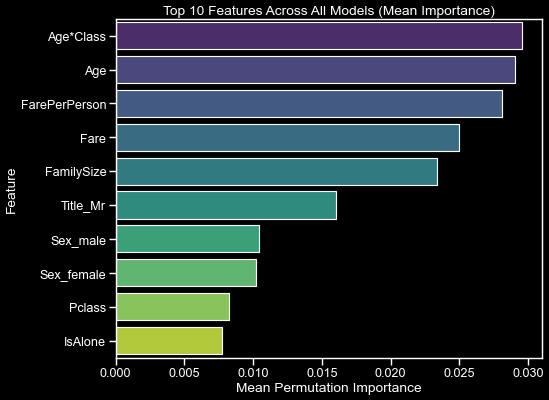

In [192]:

pi_results = {}

# Функция получения имён фичей
def get_feature_names_from_preprocessor(preprocessor, cat_cols, num_cols):
    numeric_features = preprocessor.named_transformers_['num'].get_feature_names_out(num_cols)
    ohe = preprocessor.named_transformers_['cat'].named_steps['ohe']
    cat_features = ohe.get_feature_names_out(cat_cols)
    all_features = np.concatenate([numeric_features, cat_features])
    return all_features

# Получаем имена фич
all_feature_names = get_feature_names_from_preprocessor(preprocessor, cat_cols, num_cols)

# Перебираем модели
for model_name, model in models.items():
    print(f"=== Processing model: {model_name} ===")
    
    # Создаём pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Обучаем pipeline
    pipeline.fit(X, y)
    
    # Получаем данные после трансформации
    X_transformed = pipeline.named_steps['preprocessor'].transform(X)
    if hasattr(X_transformed, "toarray"):
        X_transformed = X_transformed.toarray()
    
    # Вызываем Permutation Importance
    pi = permutation_importance(
        pipeline.named_steps['classifier'],  # Только модель
        X_transformed,                      # Данные после трансформации
        y,
        scoring='accuracy',
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )
    
    # Сохраняем результаты для данной модели
    pi_results[model_name] = {
        'importances_mean': pi.importances_mean,
        'importances_std': pi.importances_std
    }

# Агрегируем результаты
aggregated_importances = pd.DataFrame(
    {model: pi_results[model]['importances_mean'] for model in pi_results},
    index=all_feature_names
)
aggregated_importances['mean_importance'] = aggregated_importances.mean(axis=1)
aggregated_importances.sort_values('mean_importance', ascending=False, inplace=True)

# Выводим топ-10 признаков по средней важности
print("\n=== Top 10 Features Across All Models ===")
print(aggregated_importances.head(10))

# Визуализация
plt.figure(figsize=(10, 8))
sns.barplot(
    x=aggregated_importances['mean_importance'].head(10),
    y=aggregated_importances.head(10).index,
    palette='viridis'
)
plt.title("Top 10 Features Across All Models (Mean Importance)")
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Feature")
plt.show()

In [193]:
#4. Features
# ============================================================
features = [
    # Category 
    'Pclass',     
    'Sex',
    'Title',
    # Numer
    'FamilySize',
    'IsAlone',
    'Age',
    'Fare',
    'Age*Class',
    'FarePerPerson'
]
target = 'Survived'

X = train_df[features].copy()
y = train_df[target].copy()

X_test = test_df[features].copy()

cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [102]:
model_candidates = {
    'LogReg': (
        LogisticRegression(random_state=42, solver='saga', max_iter=1000),
        {
            # C (регуляризация), чем меньше C, тем сильнее регуляризация
            'classifier__C': [0.01, 0.1, 1],
            # penalty l1/l2/elasticnet (elasticnet требует solver='saga')
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
            # Для elasticnet нужен параметр l1_ratio
            'classifier__l1_ratio': [0.0, 0.5, 1.0],
            # Учет дисбаланса классов
            'classifier__class_weight': [None, 'balanced']
        }
    ),
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            # n_estimators, глубина, кол-во выборок в каждом листе
            'classifier__n_estimators': [100, 500],
            'classifier__max_depth': [5, 7],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2, 5],
            # Учет дисбаланса
            'classifier__class_weight': [None, 'balanced', 'balanced_subsample']
        }
    ),
    'XGB': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {
            # Кол-во деревьев, глубина, скорость обучения
            'classifier__n_estimators': [100, 500],
            'classifier__max_depth': [3, 5,],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            # Регуляризация
            'classifier__reg_alpha': [0, 0.1, 1],   # L1
            'classifier__reg_lambda': [1, 2, 5],    # L2
            # Сэмплинг фич/признаков (аналог bagging, colsample_bytree)
            'classifier__subsample': [ 0.8],
            'classifier__colsample_bytree': [0.8],
            # Учет дисбаланса
            'classifier__scale_pos_weight': [1, 1.5, 2] 
            # (примерно отношение классов, если класс "1" реже)
        }
    ),
    'CatBoost': (
        CatBoostClassifier(verbose=False, random_state=42),
        {
            # Кол-во итераций (деревьев), глубина
            'classifier__iterations': [200, 350, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            # Регуляризация Leaf
            'classifier__l2_leaf_reg': [1, 3, 5],
            # Учет дисбаланса (CatBoost аналог: class_weights, scale_pos_weight)
            'classifier__scale_pos_weight': [1, 1.5, 2]
        }
    ),
    'SVC': (
        SVC(random_state=42, probability=True),
        {
            # C - регуляризация (чем меньше, тем сильнее)
            'classifier__C': [0.01, 0.1, 1],
            # kernel (например, rbf, linear)
            'classifier__kernel': ['linear', 'rbf'],
            # gamma - параметр ядра
            'classifier__gamma': ['scale', 'auto'],
            # Учет дисбаланса классов
            'classifier__class_weight': [None, 'balanced']
        }
    )
}

In [103]:
# 6. КРОСС-ВАЛИДАЦИЯ (RepeatedStratifiedKFold) + GRIDSEARCH
# ==================================================================


rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

In [104]:
best_models = {}
results_summary = {}

for model_name, (model_obj, param_grid) in model_candidates.items():
    print(f"\n=== Модель {model_name} ===")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model_obj)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='accuracy',   # Цель — максимизируем Accuracy
        cv=rskf,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print("Лучшие параметры:", grid_search.best_params_)
    print(f"Лучшая Accuracy на CV: {grid_search.best_score_:.4f}")
    
    best_models[model_name] = grid_search.best_estimator_
    results_summary[model_name] = grid_search.best_score_

# ------------------------------------------------------------------
# Сводка
print("\n=== РЕЗУЛЬТАТЫ ЛУЧШИХ МОДЕЛЕЙ ===")
for m, score in results_summary.items():
    print(f"{m}: CV Accuracy = {score:.4f}")


=== Модель LogReg ===
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/envs/AI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/envs/AI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/envs/AI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/AI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/opt/anaconda3/envs/AI/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.w

Лучшие параметры: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__l1_ratio': 0.0, 'classifier__penalty': 'l2'}
Лучшая Accuracy на CV: 0.8294

=== Модель RandomForest ===
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Лучшая Accuracy на CV: 0.8384

=== Модель XGB ===
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Лучшие параметры: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 2, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}
Лучшая Accuracy на CV: 0.8518

=== Модель CatBoost ===
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Лучшие параметры: {'classifier__depth': 5,

In [105]:
# 7. ВЫБОР ЛУЧШИХ МОДЕЛЕЙ И АНСАМБЛИ
# ==================================================================
# Допустим, посмотрим, у кого лучше Accuracy
best_model_name = max(results_summary, key=results_summary.get)
best_model = best_models[best_model_name]

print(f"\nЛучшая модель по CV Accuracy: {best_model_name}, score = {results_summary[best_model_name]:.4f}")


Лучшая модель по CV Accuracy: XGB, score = 0.8518


In [106]:
# 7.1 Проверим Accuracy на всём train (осторожно, это «overfitted» оценка)
y_train_pred = best_model.predict(X)
train_acc = accuracy_score(y, y_train_pred)
print(f"Accuracy  {best_model_name}, на полном train: {train_acc:.4f}")
print(classification_report(y, y_train_pred))

# 7.2 Можно усреднить предсказания нескольких сильных моделей (Blending)
#     Например, возьмём CatBoost и XGB (если они топ-2).

model_top1 = best_models['CatBoost'] 
model_top2 = best_models['XGB']
model_top3 = best_models['RandomForest']

proba_top1 = model_top1.predict_proba(X)[:,1]
proba_top2 = model_top2.predict_proba(X)[:,1]
proba_top3 = model_top3.predict_proba(X)[:,1]
ens_proba  = (proba_top1 + proba_top2 +proba_top3 ) / 3
ens_pred   = (ens_proba >= 0.5).astype(int)

ens_acc = accuracy_score(y, ens_pred)
print(f"\nAccuracy ансамбля (CatBoost + XGB + RandomForest) на full train: {ens_acc:.4f}")


Accuracy  XGB, на полном train: 0.9091
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       549
           1       0.92      0.84      0.88       342

    accuracy                           0.91       891
   macro avg       0.91      0.90      0.90       891
weighted avg       0.91      0.91      0.91       891


Accuracy ансамбля (CatBoost + XGB + RandomForest) на full train: 0.9091


In [113]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

# Подготовим списки для сборки результатов
acc_top1_scores = []
acc_top2_scores = []
acc_top3_scores = []
acc_ensemble_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Fold {fold_idx+1} ===")
    X_train_split, X_val_split = X.iloc[train_idx], X.iloc[val_idx]
    y_train_split, y_val_split = y.iloc[train_idx], y.iloc[val_idx]
    
    # Обучаем каждую модель на train_split
    model_top1.fit(X_train_split, y_train_split)
    model_top2.fit(X_train_split, y_train_split)
    model_top3.fit(X_train_split, y_train_split)
    
    # Предсказываем для val_split (класс 0/1)
    y_pred1 = model_top1.predict(X_val_split)
    y_pred2 = model_top2.predict(X_val_split)
    y_pred3 = model_top3.predict(X_val_split)
    
    # Считаем Accuracy
    acc1 = accuracy_score(y_val_split, y_pred1)
    acc2 = accuracy_score(y_val_split, y_pred2)
    acc3 = accuracy_score(y_val_split, y_pred3)
    
    print(f" CatBoost Acc: {acc1:.4f}, XGB Acc: {acc2:.4f}, RF Acc: {acc3:.4f}")
    
    acc_top1_scores.append(acc1)
    acc_top2_scores.append(acc2)
    acc_top3_scores.append(acc3)
    
    # Теперь делаем блендинг (усредняем вероятности)
    proba1 = model_top1.predict_proba(X_val_split)[:, 1]
    proba2 = model_top2.predict_proba(X_val_split)[:, 1]
    proba3 = model_top3.predict_proba(X_val_split)[:, 1]
    
    ensemble_proba = (proba1 + proba2 ) / 2
    ensemble_pred  = (ensemble_proba >= 0.5).astype(int)
    
    acc_ens = accuracy_score(y_val_split, ensemble_pred)
    print(f" Ensemble Acc: {acc_ens:.4f}")
    
    acc_ensemble_scores.append(acc_ens)

# После цикла у нас есть 5 значений Accuracy для каждой модели и ансамбля
print("\n=== РЕЗУЛЬТАТЫ СТРАТИФИЦИРОВАННОЙ 5-FOLD CV ===")

print(f"CatBoost Mean Accuracy   = {np.mean(acc_top1_scores):.4f} ± {np.std(acc_top1_scores):.4f}")
print(f"XGB Mean Accuracy        = {np.mean(acc_top2_scores):.4f} ± {np.std(acc_top2_scores):.4f}")
print(f"RF Mean Accuracy         = {np.mean(acc_top3_scores):.4f} ± {np.std(acc_top3_scores):.4f}")
print(f"Ensemble Mean Accuracy   = {np.mean(acc_ensemble_scores):.4f} ± {np.std(acc_ensemble_scores):.4f}")


=== Fold 1 ===
 CatBoost Acc: 0.8659, XGB Acc: 0.8603, RF Acc: 0.8380
 Ensemble Acc: 0.8603

=== Fold 2 ===
 CatBoost Acc: 0.8483, XGB Acc: 0.8820, RF Acc: 0.8596
 Ensemble Acc: 0.8708

=== Fold 3 ===
 CatBoost Acc: 0.8483, XGB Acc: 0.8371, RF Acc: 0.8146
 Ensemble Acc: 0.8315

=== Fold 4 ===
 CatBoost Acc: 0.8371, XGB Acc: 0.8315, RF Acc: 0.8371
 Ensemble Acc: 0.8371

=== Fold 5 ===
 CatBoost Acc: 0.8539, XGB Acc: 0.8483, RF Acc: 0.8427
 Ensemble Acc: 0.8539

=== Fold 6 ===
 CatBoost Acc: 0.8324, XGB Acc: 0.8156, RF Acc: 0.7989
 Ensemble Acc: 0.8380

=== Fold 7 ===
 CatBoost Acc: 0.8539, XGB Acc: 0.8371, RF Acc: 0.8427
 Ensemble Acc: 0.8371

=== Fold 8 ===
 CatBoost Acc: 0.8146, XGB Acc: 0.8202, RF Acc: 0.8146
 Ensemble Acc: 0.8202

=== Fold 9 ===
 CatBoost Acc: 0.8146, XGB Acc: 0.8483, RF Acc: 0.8034
 Ensemble Acc: 0.8371

=== Fold 10 ===
 CatBoost Acc: 0.8483, XGB Acc: 0.8315, RF Acc: 0.8371
 Ensemble Acc: 0.8427

=== Fold 11 ===
 CatBoost Acc: 0.8324, XGB Acc: 0.8492, RF Acc: 0.83

In [111]:
final_proba_test =  model_top2.predict_proba(X_test)[:,1] 
final_pred_test  = (final_proba_test >= 0.5).astype(int)

In [112]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': final_pred_test
})
submission.to_csv('submission.csv', index=False)